# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measured by variance)
    """
    if np.size(y) == 0:
        return 0.0
    return np.sum(np.abs(y - np.mean(y))) / np.size(y)

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """

    x_column = X[:, j]

    y_right = y[x_column > t]
    y_left = y[x_column <= t]

    impurity_left = H(y_left)
    impurity_right = H(y_right)

    return impurity_left * len(y_left) / len(y) + impurity_right * len(y_right) / len(y)

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    min_samples_leaf : int
        Minimal number of samples (objects) in a leaf (terminal node).
    """

    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    # чтобы не было warning
    def _more_tags(self):
        return {
            'requires_y': False
        }

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """

        best_split_column = None
        best_threshold = None
        best_cost = H(y)

        # ищем столбец с наименьшим значением loss функции
        for split_column in range(X.shape[1]):
            x_col = X[:, split_column]
            for i_x in range(0, len(x_col)):
                threshold = x_col[i_x]

                cost = Q(X, y, split_column, threshold)

                if cost < best_cost:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_cost = cost

        # если разделить не получится
        if best_cost == H(y):
            return None, None, None, None, None, None

        x_column = X[:, best_split_column]
        # делим на правого и левого детей
        x_left = X[x_column <= best_threshold, :]
        y_left = y[x_column <= best_threshold]
        x_right = X[x_column > best_threshold, :]
        y_right = y[x_column > best_threshold]

        return best_split_column, best_threshold, x_left, y_left, x_right, y_right

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node.
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """

        # проверки взяты с семинара
        if self.is_terminal(node, y):
            node.is_terminal = True
            return

        if node.depth >= self.max_depth:
            node.is_terminal = True
            return
        if len(X) < self.min_samples_split:
            node.is_terminal = True
            return
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return

        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:
            node.is_terminal = True
            return

        node.column = split_column
        node.threshold = threshold

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """

        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]

        # Initialize the tree (root node)
        self.tree_ = Node()
        self.tree_.depth = 0
        self.tree_.prediction = np.mean(y)

        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """

        if node.is_terminal:
            return node.prediction

        if x[node.column] > node.threshold:
            return self.get_prediction(node.right, x)
        else:
            return self.get_prediction(node.left, x)

    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model

In [8]:
from sklearn.datasets import load_boston

# loading dataset
boston_dataset = load_boston()
X_boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
y_boston = boston_dataset.target

/Users/shmelzzz/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California ho

In [9]:
from sklearn.model_selection import train_test_split

# split
x_train, x_test, y_train, y_test = train_test_split(X_boston, y_boston, train_size=0.75, random_state=42)

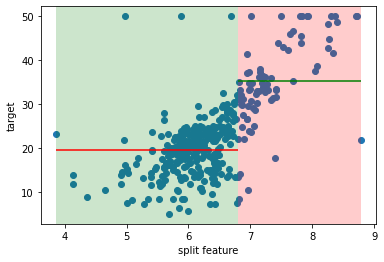

In [37]:
tree_regr = MyDecisionTreeRegressor(max_depth=1)
tree_regr.fit(x_train, y_train)

plt.scatter(x_train.iloc[:,tree_regr.tree_.column], y_train)
plt.xlabel('split feature')
plt.ylabel('target')

plt.axvspan(xmin=np.min(x_train.iloc[:, tree_regr.tree_.column]), xmax=tree_regr.tree_.threshold, facecolor='green',
            alpha=0.2)
plt.axvspan(xmax=np.max(x_train.iloc[:, tree_regr.tree_.column]), xmin=tree_regr.tree_.threshold, facecolor='red',
            alpha=0.2)
plt.hlines(y=tree_regr.tree_.left.prediction, xmin=np.min(x_train.iloc[:, tree_regr.tree_.column]),
           xmax=tree_regr.tree_.threshold, color='r')
plt.hlines(y=tree_regr.tree_.right.prediction, xmax=np.max(x_train.iloc[:, tree_regr.tree_.column]),
           xmin=tree_regr.tree_.threshold, color='g')
plt.show()

Так как из-за max_depth=1 был всего лишь один сплит, fitted model - это threshold этого сплита и predictions в каждом из детей. Threshold показан разделением фона графика, а предсказания в каждом ребенке - линии.
Таким образом, на зеленом фоне - объекты в левом ребенке и его prediction, на красном фоне - объекты в правом ребенке и его prediction.

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator.

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

tree_regression = MyDecisionTreeRegressor()
parameters = {'max_depth': [1, 3, 5, 7, 9, 10],
              'min_samples_leaf': [1, 2, 3, 5, 7, 10, 15]}
tree = GridSearchCV(tree_regression, parameters, scoring='neg_mean_absolute_error', cv=5)
tree.fit(x_train, y_train)
print("Best parameters: ", tree.best_params_)

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 2}


In [39]:
pred = tree.predict(x_test)

In [40]:
print('MAE:', (mean_absolute_error(y_test, pred)))

MAE: 2.610396592637237


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [41]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    np.random.seed(42)

    # массив индексов объектов в датасете
    rows_index = np.arange(start=0, stop=x.shape[0], step=1)
    rows_count = x.shape[0]

    # создадим пустой массив, в который будут добавлятся предсказания для каждого сэмпла
    predictions = np.empty(shape=(n_iter, x.shape[0]))
    predictions[:] = np.nan

    for i in range(n_iter):
        # выбираем рандомные индексы объектов из датасета
        random_rows_ind = np.random.choice(rows_index, rows_count, replace=True)
        # обпределяем, какие объекты не попали в сэмпл
        oob_ind = [ind for ind in rows_index if ind not in random_rows_ind]

        estimator.fit(x[random_rows_ind,:],y[random_rows_ind])
        oob_y_predict = estimator.predict(x[oob_ind,:])
        # добавляем предсказания в массив
        predictions[i, oob_ind] = oob_y_predict

    bias = np.nanmean(np.square(y - np.nanmean(predictions, axis=0)))
    variance = np.nanmean(np.square(np.nanstd(predictions, axis=0)))

    return bias, variance

In [42]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, x_train.values, y_train, 10)

(18.777375507281608, 10.192201556239318)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [43]:
bias = []
variance = []

min_samples_arr = np.arange(start=1, stop=100, step=5)

for i in min_samples_arr:
    tree_estimator = MyDecisionTreeRegressor(max_depth = 10, min_samples_split=i)
    cur_bias, cur_variance = get_bias_variance(tree_estimator, x_train.values, y_train, 10)
    bias.append(cur_bias)
    variance.append(cur_variance)

Text(0.5, 0, 'min_samples_split')

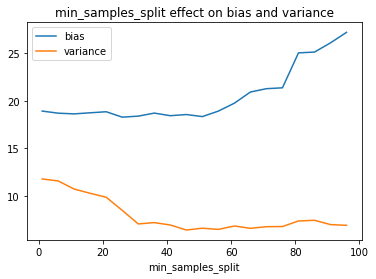

In [44]:
plt.plot(min_samples_arr, bias)
plt.plot(min_samples_arr, variance)
plt.legend(['bias', 'variance'])
plt.title('min_samples_split effect on bias and variance')
plt.xlabel('min_samples_split')

В теории большой разброс (variance) значит, что модель переобучена; большое смещение (bias) значит, что модель не дообучилась.
На графике видно, что чем больше значение минимального разбиения, тем больше становится смещение. Это происходит из-за того, что большое значение min_samples_split не позволяет дереву сильно расзарстись вглубь (max_depth не будет очень большим при большом значении min_samples_split), что ведет к недообучению модели.
Также видно, что при увеличении значения min_samples_split уменьшается разброс. Как было помянуто выше, это происходит из-за того, что глубина дерева не может получится очень большой при большом значении min_samples_split. Следовательно, модель на маленьких значениях min_samples_split переобучается.
График соответствует теории.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [45]:
from sklearn.ensemble import BaggingRegressor

tree_estimator_bagging = BaggingRegressor(base_estimator=
                                          MyDecisionTreeRegressor(max_depth=10, min_samples_split=10),
                                          n_estimators=40, random_state=42)

bagging_bias, bagging_variance = get_bias_variance(tree_estimator_bagging, x_train.values, y_train, 10)
print('Bias: ', bagging_bias)
print('Variance: ', bagging_variance)

Bias:  15.28504787038091
Variance:  1.698725158954505


В теории bagging уменьшает разброс, но при этом никак не влияет на смещение.
В сравнении со смещением и разбросом в 6-ом задании разброс значительно уменьшился, в то время как смещение тоже изменилось в меньшую сторону, но не намного.
Результаты сходятся с теорией

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [46]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [48]:
print('Dataset shape: ', X.shape)
print('Missing values count:\n', pd.isnull(X).sum())

Dataset shape:  (3772, 29)
Missing values count:
 age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          377

Так как в столбце TBG находятся только пустые значения (их кол-во равно размеру датасета), его можно удалить.
Так же больше всего значений пропущено в столбцах T3, T4U, FTI. Но так как кол-во пропущенных значений в этих столбцах не превышает 20% от всего датасета, их мы удалять не будем.

In [49]:
X = X.drop('TBG', axis=1)

In [50]:
from sklearn.model_selection import train_test_split

x_train_disease, x_test_disease, y_train_disease, y_test_disease = train_test_split(X, y, train_size=0.75, random_state=42)

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

categorical = X.select_dtypes(include=['object']).columns.tolist()
numerical = X.select_dtypes(exclude=['object']).columns.tolist()

categorical_transform = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
numerical_transform = SimpleImputer(strategy='mean')

column_transformer = ColumnTransformer([('numerical', numerical_transform, numerical),
                                        ('categorical', categorical_transform, categorical)],
                                         remainder='passthrough')

x_train_disease = column_transformer.fit_transform(x_train_disease)
x_test_disease = column_transformer.transform(x_test_disease)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [52]:
pd.value_counts(y)

0    3541
1     231
dtype: int64

Классы не сбалансированы. Следовательно, нужно использовать StratifiedKFold, который берет примерно равное кол-во объектов разных классов, то есть подходит в случае, когда классы не сбалансированы.

Метрика F1-score подходит для классификации, даже при условии несбалансированности классов.

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

skf = StratifiedKFold(n_splits=5)

score_GB = cross_val_score(GradientBoostingClassifier(random_state=42, n_estimators=50), x_train_disease, y_train_disease, cv=skf, scoring='f1')
print("Gradient Boosting: F1-score = %.4f" % score_GB.mean())

score_RF = cross_val_score(RandomForestClassifier(random_state=42, n_estimators=50), x_train_disease, y_train_disease, cv=skf, scoring='f1')
print("Random Forest: F1-score = %.4f" % score_RF.mean())

score_DT = cross_val_score(DecisionTreeClassifier(random_state=42, max_depth=10), x_train_disease, y_train_disease, cv=skf, scoring='f1')
print("Decision Tree: F1-score = %.4f" % score_DT.mean())

score_SVM = cross_val_score(SVC(random_state=42), x_train_disease, y_train_disease, cv=skf, scoring='f1')
print("SVM: F1-score = %.4f" % score_SVM.mean())

score_LR = cross_val_score(LogisticRegression(random_state=42, max_iter=10000), x_train_disease, y_train_disease, cv=skf, scoring='f1')
print("Logistic Regression: F1-score = %.4f" % score_LR.mean())

Gradient Boosting: F1-score = 0.8656
Random Forest: F1-score = 0.8425
Decision Tree: F1-score = 0.8827
SVM: F1-score = 0.0000
Logistic Regression: F1-score = 0.6807


* Лучше всего метрики у Decision tree.
* SVM для данной задачи классификации не подходит.
* Логистическая регрессия уступает деревьям по качеству.


### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to implement one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

To get method that you have to implement, run cell below and input your name in Russian (for example, if you input Андрей, you will see that user with this name should implement xgboost)

In [54]:
def assign_method():
    name = 'Елизавета'
    methods = ['xgboost', 'lightgbm', 'catboost']
    idx = sum([ord(x) for x in list(name)]) % 3
    print('Реализуйте', methods[idx])
    
assign_method()

Реализуйте xgboost


In [55]:
from xgboost import XGBClassifier

boosting = XGBClassifier(objective='binary:logistic', seed=42)

parameters_boosting = {'max_depth': range(2, 10, 1),
                       'n_estimators': range(50, 300, 50),
                       'learning_rate': [1.0, 0.1, 0.01]}

xgboost = GridSearchCV(boosting, parameters_boosting, scoring='f1', cv=StratifiedKFold(n_splits=5), verbose=True)
xgboost.fit(x_train_disease, y_train_disease)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                

In [56]:
print('Best parameters: ', xgboost.best_params_)
print('F1 on test:', f1_score(y_test_disease, xgboost.predict(x_test_disease)))
print('F1 on train:', f1_score(y_train_disease, xgboost.predict(x_train_disease)))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}
F1 on test: 0.8910891089108911
F1 on train: 1.0


Качество модели сопоставимо с качеством деревьев из предыдущего задания, f1-score увеличился не намного по сравнению с Decision Tree.

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [60]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

decision_tree_bagging = BaggingClassifier(DecisionTreeClassifier(), random_state=42)
decision_tree_bagging.fit(x_train_disease, y_train_disease)
print('Bagging with decision trees as base estimators:')
print('F1 for test:', f1_score(y_test_disease, decision_tree_bagging.predict(x_test_disease)))
print('F1 for train:', f1_score(y_train_disease, decision_tree_bagging.predict(x_train_disease)))

Bagging with decision trees as base estimators:
F1 for test: 0.9
F1 for train: 0.9944444444444445


In [61]:
gr_boosting_bagging = BaggingClassifier(GradientBoostingClassifier(n_estimators=200, random_state=42), random_state=42)
gr_boosting_bagging.fit(x_train_disease, y_train_disease)
print('Bagging with gradient boosting (with large amount of trees, >100) as base estimators: ')
print('F1 for test:', f1_score(y_test_disease, gr_boosting_bagging.predict(x_test_disease)))
print('F1 for train:', f1_score(y_train_disease, gr_boosting_bagging.predict(x_train_disease)))

Bagging with gradient boosting (with large amount of trees, >100) as base estimators: 
F1 for test: 0.9
F1 for train: 0.9831460674157304


In [62]:
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))])
voting_clf.fit(x_train_disease, y_train_disease)
print('Voting Classifier:')
print('F1 for test:', f1_score(y_test_disease, voting_clf.predict(x_test_disease)))
print('F1 for train:', f1_score(y_train_disease, voting_clf.predict(x_train_disease)))

Voting Classifier:
F1 for test: 0.8514851485148515
F1 for train: 1.0


In [63]:
stacking_logit = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))],
    final_estimator=LogisticRegression())
stacking_logit.fit(x_train_disease, y_train_disease)
print('Stacking Classifier with Logistic Regression as a final model:')
print('F1 for test:', f1_score(y_test_disease, stacking_logit.predict(x_test_disease)))
print('F1 for train:', f1_score(y_train_disease, stacking_logit.predict(x_train_disease)))

Stacking Classifier with Logistic Regression as a final model:
F1 for test: 0.8659793814432989
F1 for train: 1.0


In [64]:
stacking_gr_boosting = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))],
    final_estimator=GradientBoostingClassifier(random_state=42))
stacking_gr_boosting.fit(x_train_disease, y_train_disease)
print('Stacking Classifier with Gradient Boosting as a final model:')
print('F1 for test:', f1_score(y_test_disease, stacking_gr_boosting.predict(x_test_disease)))
print('F1 for train:', f1_score(y_train_disease, stacking_gr_boosting.predict(x_train_disease)))

Stacking Classifier with Gradient Boosting as a final model:
F1 for test: 0.8686868686868686
F1 for train: 0.9888888888888889


### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [65]:
print('Bagging with decision trees as base estimators is best model:')
print('F1 for test:', f1_score(y_test_disease, decision_tree_bagging.predict(x_test_disease)))

Bagging with decision trees as base estimators is best model:
F1 for test: 0.9
